<h1 style="text-align: center;"> Classification of Human Facial Expressions </h1>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Santiago Becerra Cordoba</strong>  
<br>
sab1475@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Sarah Kim</strong>  
<br>
gak604@g.harvard.edu
</div>


<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Chloe Seo</strong>  
<br>
yes593@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Kaylee Vo</strong>  
<br>
kav418@g.harvard.edu
</div>

## Table of Contents

1. [Data Overview](#data-overview)
    - [Data Description](#data-description)
    - [Data Summary](#data-summary)

2. [Data Analysis](#data-analysis)
    - [a. Missing Data](#missing-data)
    - [b. Data Imbalance](#data-imbalance)
    - [c. Denoising](#denoising)
    - [d. Outlier Detection](#outlier-detection)
    - [e. Meaningful Insights](#meaningful-insights)

3. [Research Question](#research-question)

4. [Baseline Model](#baseline-model)

5. [Visualizations](#visusalizations)
    - [a. Activation Maximization](#activation-maximization)
    - [b. GradCAM](#gradcam)

6. [Sources](#sources)

7. [Appendix](#appendix)

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Jie Zhao</strong>  
<br>
jiz273@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong></strong>  
<br>
</div>

<h5 style="text-align: center;"> ALM Data Science, Harvard University </h5>

## Data Overview

### Data Description

In this project, we aim to classify human facial expressions using a dataset of images. The data we will use is the FER-2013 dataset, which contains 35,887 grayscale images of size 48x48 pixels. Each image is labeled with one of seven emotions: anger, disgust, fear, happiness, sadness, surprise, and neutral. The data itself came with a train and test set. We split the train set into a train and validation set with 20% of the data going to the validation set.

The introduction has three sections: access, load, and understand. In the access section, we perform data engineering tasks to pull the data and prep the local directory structure. The data is too large to be kept in a repository, so this step is necessary for development. In the load section, we load the data into memory with Keras image generators. Finally in the Understand section, we sample a subset of images and present simple summaries and visualizations to better understand the data.

#### Access

For this section we import libraries and write code to automatically pull the data from the internet. The code fetches from Kaggle and stores it in the users' cache. The code that moves the data from the cache to the project directory.

In [6]:
import os
import pathlib
import time
import zipfile
import random
import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import time
import tarfile
import gdown
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise, UpSampling2D
from tensorflow.keras.layers import (
    Flatten,
    Input,
    InputLayer,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Reshape,
)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tqdm
import shutil
import platform
import cv2
import kagglehub
from keras.utils import set_random_seed

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler

In [7]:
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

Path to dataset files: /shared/home/yes593/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [8]:
DATA_DIR = os.getcwd() + "/data"

# For mac users
if platform.system() == "Darwin":
    os.system('find . -name ".DS_Store" -delete')

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [9]:
# if data folder is empty, copy files from the dataset folder
if not os.listdir(DATA_DIR):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)

        if os.path.isfile(item_path):
            shutil.copy(item_path, DATA_DIR)
            print(f"Copied file: {item_path}")
        elif os.path.isdir(item_path):
            shutil.copytree(item_path, os.path.join(DATA_DIR, item))
            print(f"Copied directory: {item_path}")

#### Load

The data was already given in a directory structure. We leverage this in order loading code. After a 20% validaiton split, we have 22968 images in the training set, 5741 images in the validation set, and 7178 images in the test set. The total number of images is 35887. The images are scaled by dividing by 255. Note this is arbitrary for now and may be adjusted in the future.

In [10]:
train_dir = DATA_DIR + "/train"
val_dir = DATA_DIR + "/validation"
val_split = 0.2
random.seed(109)

if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        val_class_path = os.path.join(val_dir, class_name)
        os.makedirs(val_class_path, exist_ok=True)

        # List all images in the class directory
        images = os.listdir(class_path)
        random.shuffle(images)

        # Move a portion of images to validation
        num_val = int(len(images) * val_split)
        for img in images[:num_val]:
            shutil.move(
                os.path.join(class_path, img), os.path.join(val_class_path, img)
            )

In [11]:
datagen = ImageDataGenerator(rescale=1.0 / 255)

In [12]:
batch_size = 32
target_size = (48, 48)  # generator can resize all images if we want

traingen = datagen.flow_from_directory(
    DATA_DIR + "/train",  # this is the target directory
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)
valgen = datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

testgen = datagen.flow_from_directory(
    DATA_DIR + "/test",
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode="sparse",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
total_images = traingen.samples + valgen.samples + testgen.samples

print("Total images in dataset:", total_images)

Total images in dataset: 35887


#### Understand

The batch size is set to 32 but this is arbitrary and is subject to change. The dimensions of the images are 48x48 with a single channel (e.g. grayscale images). The number of classes is 7, corresponding to the 7 emotions. The mapping from integer to emotion is shown in a cell below. We also present a set of 8 images to preview the data. The images match well with their labels. One aspect to note is the existence of watermarks in some of the images. This is a potential source of noise in the data that will need to be addressed in the preprocessing step.

In [14]:
data_batch, labels_batch = next(traingen)
print("data batch shape:", data_batch.shape)
print("labels batch shape:", labels_batch.shape)

data batch shape: (32, 48, 48, 1)
labels batch shape: (32,)


In [15]:
class_indices = traingen.class_indices
class_labels = {v: k for k, v in class_indices.items()}

In [16]:
class_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

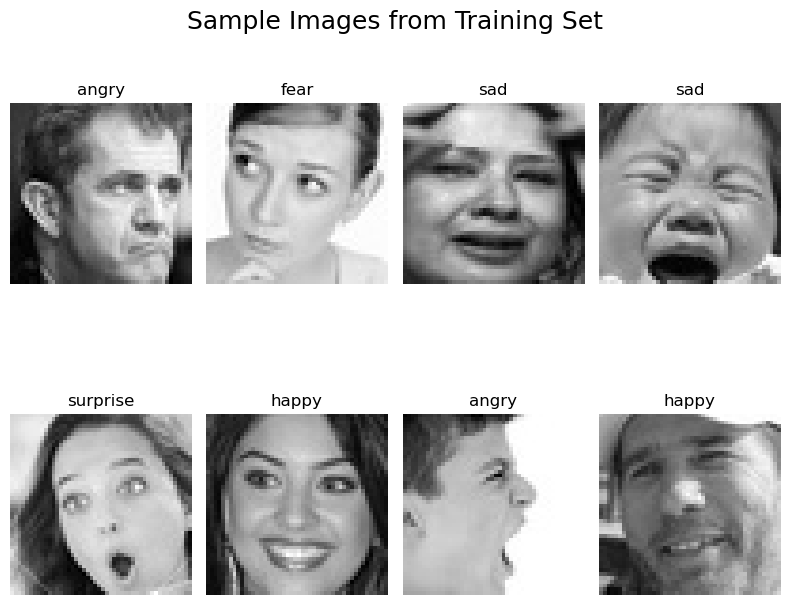

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(8, 8))

axs = ax.ravel()

counter = 0
for batch, labels in traingen:
    for img, label in zip(batch, labels):
        class_index = int(label)
        class_name = class_labels[class_index]

        axs[counter].imshow(img[:, :, 0], cmap="gray")
        axs[counter].set_title(class_name)
        axs[counter].axis("off")

        counter += 1
        if counter >= 8:
            break

    break

plt.suptitle("Sample Images from Training Set", y=0.9, fontsize=18)
plt.tight_layout()

### Data Summary

In [18]:
# TODO: Data Description and Summary of the Data
# 0. Incorporate any feedback from TA into the data description section above
# 1. Paragraph summary of the data
# 2. Flow chart of the data pipeline
# - kaggle download, validation split, etc, all the way to the model

In [19]:
data_batch, labels_batch = next(traingen)
print("Shape of data batch:", data_batch.shape)
print("Class labels:", class_labels)

print("Pixel data summary:")
print(f"Dtype: {data_batch.dtype}")
print(f"Mean: {data_batch.mean():.2f}")
print(f"Std : {data_batch.std():.2f}")
print(f"Min : {data_batch.min()}")
print(f"Max : {data_batch.max()}")

Shape of data batch: (32, 48, 48, 1)
Class labels: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
Pixel data summary:
Dtype: float32
Mean: 0.56
Std : 0.24
Min : 0.0
Max : 1.0


The dataset include 35,887 images, and each of image is 48×48 grayscale facial images labeled with one of 7 emotions: 'angry','disgust', 'fear','happy','neutral','sad','surprise'.The data is split into training (22,968 images), validation (5,741 images), and test (7,178 images) using an 80/20 split. We use this dataset to train a classification model that identify the human emotion expressed face images. The pixel values have been normalized to the range [0.0, 1.0]. Summary statistics of the pixel values show a mean of 0.51, standard deviation of 0.26, with a minimum of 0.0 and maximum of 1.0. It shows data are properly scaled and centered around mid values.


The flow chart below shows the data pipeline
(will adjust as we progress)

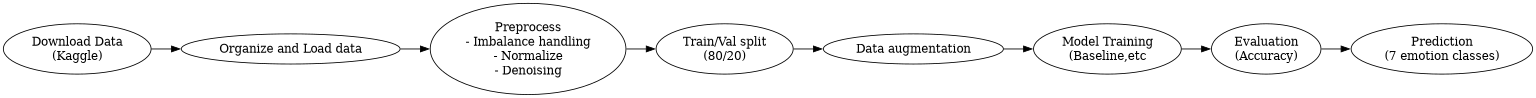

In [20]:
from graphviz import Digraph

dot = Digraph(comment="Data Pipeline")

dot.attr(size="16,10")
dot.attr(rankdir="LR")

# Nodes
dot.node("A", "Download Data\n(Kaggle)")
dot.node("B", "Organize and Load data")
dot.node("C", "Preprocess\n- Imbalance handling\n- Normalize\n- Denoising")
dot.node("D", "Train/Val split\n(80/20)")
dot.node("E", "Data augmentation")
dot.node("F", "Model Training\n(Baseline,etc")
dot.node("G", "Evaluation\n(Accuracy)")
dot.node("H", "Prediction\n(7 emotion classes)")

dot.edges(["AB", "BC", "CD", "DE", "EF", "FG", "GH"])

dot.render("facial_expression_pipeline_flowchart", format="png", cleanup=True)

from IPython.display import Image

Image(filename="facial_expression_pipeline_flowchart.png")

## Data Analysis

### Missing Data

In [21]:
traingen.reset()
testgen.reset()

missing_count_train = 0
total_pixels_train = 0
missing_count_test = 0
total_pixels_test = 0

for i in range(len(traingen)):
    batch_images, batch_labels = next(traingen)
    missing_count_train += np.isnan(batch_images).sum()
    total_pixels_train += batch_images.size

for i in range(len(testgen)):
    batch_images, batch_labels = next(testgen)
    missing_count_test += np.isnan(batch_images).sum()
    total_pixels_test += batch_images.size

print("--Training Set--")
print(f"Missing pixel values: {missing_count_train}")
print(f"Total pixels:         {total_pixels_train}")
if total_pixels_train > 0:
    pct_train = (missing_count_train / total_pixels_train) * 100
    print(f"Percentage missing:   {pct_train:.2f}%")
else:
    print("No pixels found")

print("\n--Test Set--")
print(f"Missing pixel values: {missing_count_test}")
print(f"Total pixels:         {total_pixels_test}")
if total_pixels_test > 0:
    pct_test = (missing_count_test / total_pixels_test) * 100
    print(f"Percentage missing:   {pct_test:.2f}%")
else:
    print("No pixels found")

if missing_count_train == 0 and missing_count_test == 0:
    print(
        "\nObservation: There are no missing pixel values in either training or test sets. "
    )
else:
    print("\nObservation: Some missing pixel values were found.")

--Training Set--
Missing pixel values: 0
Total pixels:         52918272
Percentage missing:   0.00%

--Test Set--
Missing pixel values: 0
Total pixels:         16538112
Percentage missing:   0.00%

Observation: There are no missing pixel values in either training or test sets. 


Checked through the training (traingen) and test (testgen) datasets for any missing pixel values by looping through every image batch and counting NaNs. As a result, there were no missing pixels found. 

### Data Imbalance

The training set shows clear class imbalance:

- **Underrepresented**:
  - *Disgust* (fewer than 1,000 images)
  - *Surprise*
- **Overrepresented**:
  - *Happy* (nearly 6,000 images)

This imbalance can bias the model toward majority classes and reduce accuracy on minority ones like *disgust* and *surprise*. To improve robustness and generalization, we applied data augmentation (e.g., rotation, zoom, flipping) to the entire training set. While this doesn’t rebalance class frequency, it helps prevent overfitting and exposes the model to more varied inputs.

If this approach proves insufficient, we’ll explore more targeted strategies—such as oversampling underrepresented classes or applying heavier augmentation selectively.

Additionally, we computed `class_weight` values to be used during model training. These weights adjust the loss function to penalize misclassifications of rare classes more heavily. For example, *disgust* has a weight of **9.4**, while *happy* has a weight of **0.57**. This encourages the model to pay more attention to minority classes during learning.

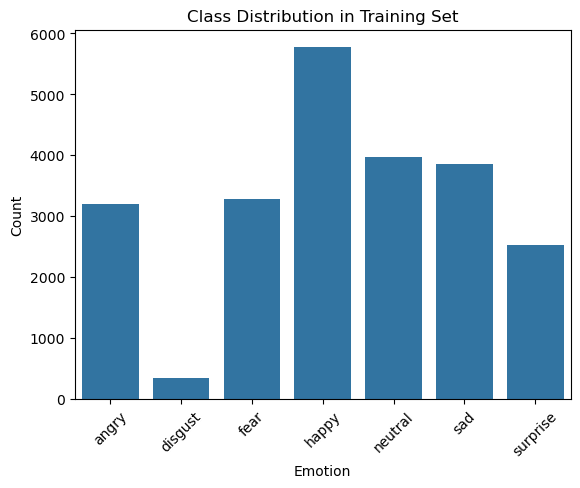

In [22]:
# Check if there is class imbalance
# Get class labels from traingen (not just a batch but all)
labels = traingen.classes
class_indices = traingen.class_indices
class_labels = {v: k for k, v in class_indices.items()}

label_names = [class_labels[label] for label in labels]
sns.countplot(x=label_names, order=sorted(set(label_names)))
plt.title("Class Distribution in Training Set")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [23]:
# Add added data augmentation to train dataset to improve robustness
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

# keep the rescale only for validation & test data
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [24]:
# Update the generator
traingen = train_datagen.flow_from_directory(
    DATA_DIR + "/train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

valgen = val_test_datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

testgen = val_test_datagen.flow_from_directory(
    DATA_DIR + "/test",
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode="sparse",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [25]:
# Add class weight

labels = traingen.classes
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(labels), y=labels
)
class_weights_dict = dict(enumerate(class_weights))

print(
    "Class weights:", class_weights_dict
)  # we could use this class_weight when we fit the model

Class weights: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


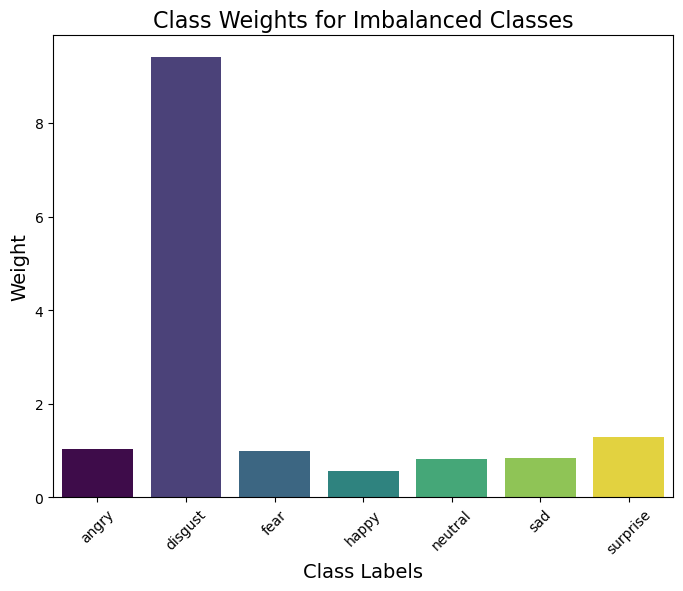

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

labels, values = list(class_weights_dict.keys()), list(class_weights_dict.values())
sns.barplot(x=labels, y=values, hue=labels, palette="viridis")
ax.legend_.remove()
ax.set_xticks(labels, labels=class_labels.values(), rotation=45)

ax.set_title("Class Weights for Imbalanced Classes", fontsize=16)
ax.set_ylabel("Weight", fontsize=14)
ax.set_xlabel("Class Labels", fontsize=14)
plt.show()

As expected, the class weights are inversely proportional to the number of samples in each class. The class weights for `digust` are the largest, while the class weights for `happy` are the smallest. 

### Denoising

#### Non-Local Means Denoising

Non-local means (NLM) is a denoising technique that differs from local filters by considering the entire image for noise reduction. It does so by computing a mean for all pixels in the image, weighted by how similar these pixels are to the target pixel. We attempt to apply this technique to alleviate the water mark issue seen in some of the images. We use OpenCV library which can easily be integrated into tensorflow via a custom layer. We hand pick a set of four images to test this denoising approach. A thorough formulation of this approach can be found in the Appendix.

Watermarks are typically horizontal, and can appear at the top, bottom, or center of the image. Their color could be light, dark, and in some cases, they overlap with facial features. 

In [27]:
watermarked_images = [
    "fear/Training_7118915.jpg",
    "happy/Training_10229138.jpg",
    "neutral/Training_15579995.jpg",
    "sad/Training_20437400.jpg",
]

In [28]:
def read_image(path):
    watermark_img_bytes = tf.io.read_file(path)
    watermark_image_tensor = tf.image.decode_image(watermark_img_bytes, channels=3)

    return watermark_image_tensor

2025-04-16 23:57:36.074994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:3c:00.0, compute capability: 8.9


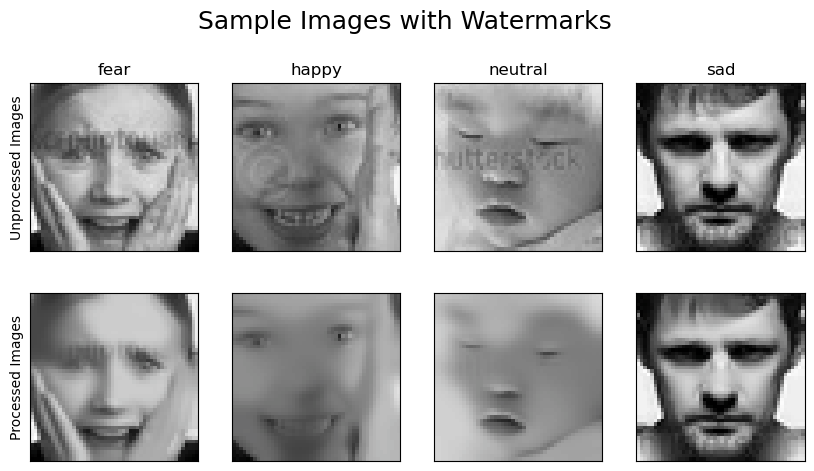

In [29]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

counter = 0

for image_path in watermarked_images:
    image = read_image("./data/train/" + image_path)
    axs[0, counter].imshow(image, cmap="gray")
    axs[0, counter].set_title(image_path.split("/")[0])

    denoised_image = cv2.fastNlMeansDenoisingColored(
        image.numpy(),
        None,
        # Strength of the filter
        h=10,
        # Size in pixels of the template patch that is used to compute weights.
        templateWindowSize=7,
        # Size in pixels of the window that is used to compute weighted average for given pixel
        searchWindowSize=21,
    )
    axs[1, counter].imshow(denoised_image, cmap="gray")

    if counter == 0:
        axs[0, 0].set_ylabel("Unprocessed Images")
        axs[1, 0].set_ylabel("Processed Images")

    axs[0, counter].set_xticks([])
    axs[0, counter].set_yticks([])
    axs[1, counter].set_xticks([])
    axs[1, counter].set_yticks([])

    counter += 1

plt.suptitle("Sample Images with Watermarks", y=1.02, fontsize=18)
plt.show()

In [30]:
# check the impact of mask on a image without watermark
non_watermarked_image = read_image(
    os.path.join(DATA_DIR, "train", "surprise", "Training_737165.jpg")
)

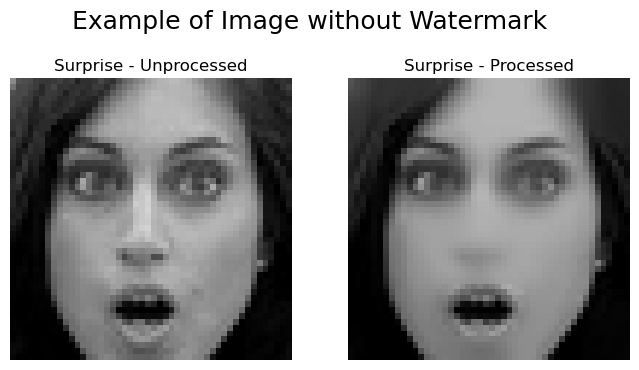

In [31]:
non_watermarked_image_processed = cv2.fastNlMeansDenoisingColored(
    non_watermarked_image.numpy(),
    None,
    # Strength of the filter
    h=12,
    # Size in pixels of the template patch that is used to compute weights.
    templateWindowSize=7,
    # Size in pixels of the window that is used to compute weighted average for given pixel
    searchWindowSize=21,
)


fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(non_watermarked_image, cmap="gray")
ax[0].set_title("Surprise - Unprocessed")
ax[0].axis("off")

ax[1].imshow(non_watermarked_image_processed, cmap="gray")
ax[1].set_title("Surprise - Processed")
ax[1].axis("off")

plt.suptitle("Example of Image without Watermark", y=1.02, fontsize=18)
plt.show()

The results are decent but as expected there is a tradeoff. Since facial skin tones tend to be consistent, the method performed fine on the first image. However we lose image detail when we apply NLM. It overly smoothed facial details like bluring eyes, as with the case for the second and third images. The watermark is less visible but the image is also less clear. In the fourth case, the watermark can still be seen. We wrap up the section with an example of an image without a water and as one can see the details are erased.

We tried other strategies like Gaussian denoising but the results were not as good. The image lost detail in addition to not removing the watermark. This approach was omitted from this notebook.

It remains to be determined if the watermark even has a significant impact on future model performance. Since watermarks vary and only affect a small number of images, the approach for now may be to rely on data augmentation to improve generalization and reduce overfitting.

#### Future Work

The strategy going forward will be to train a model without any denoising and then try a model with Gaussian denoising and NLM. If both strategies fail, we will try to use autoencoders to remove the watermark. We will use the watermarked image and the denoised image as training pairs to hopefully create images that are more clear. A simple example of this is found in Lab 6 using Gaussian blur.

### Outlier Detection

In [32]:
# TODO: Data Analysis
# - Outlier Detection

all_train_imgs = []
steps = traingen.samples // traingen.batch_size
for i in range(steps):
    batch_imgs, _ = next(traingen)
    all_train_imgs.append(batch_imgs)
all_train_imgs = np.concatenate(all_train_imgs, axis=0)
print("Total training images extracted for outlier detection:", all_train_imgs.shape)

autoencoder = Sequential([
    Input(shape=(48, 48, 1)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

history = autoencoder.fit(all_train_imgs, all_train_imgs, epochs=10, batch_size=traingen.batch_size, validation_split=0.1, verbose=1)

reconstructions = autoencoder.predict(all_train_imgs)
reconstruction_error = np.mean(np.square(all_train_imgs - reconstructions), axis=(1, 2, 3))

# Setting up threshold to 98% (initially, started off with 95th percentile, but increased to 98th percentile)
threshold = np.percentile(reconstruction_error, 98)
print("Reconstruction error threshold for outliers:", threshold)

is_outlier = reconstruction_error > threshold
print(f"Number of outliers detected: {np.sum(is_outlier)}")

clean_train_imgs = all_train_imgs[~is_outlier]
print("Shape of clean training images after outlier removal:", clean_train_imgs.shape)


Total training images extracted for outlier detection: (22944, 48, 48, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 64)        256       
 chNormalization)                               

2025-04-16 23:58:20.872386: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-16 23:58:23.058047: I external/local_xla/xla/service/service.cc:168] XLA service 0x15094145bcc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-16 23:58:23.058084: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-04-16 23:58:23.062185: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744862303.134872   35245 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


646/646 [==============================] - 8s 5ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 2/10
646/646 [==============================] - 3s 4ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 3/10
646/646 [==============================] - 3s 4ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/10
646/646 [==============================] - 3s 4ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/10
646/646 [==============================] - 3s 4ms/step - loss: 0.0016 - val_loss: 9.3801e-04
Epoch 6/10
646/646 [==============================] - 3s 4ms/step - loss: 0.0014 - val_loss: 7.8928e-04
Epoch 7/10
646/646 [==============================] - 3s 4ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/10
646/646 [==============================] - 3s 4ms/step - loss: 0.0012 - val_loss: 8.7840e-04
Epoch 9/10
646/646 [==============================] - 3s 4ms/step - loss: 0.0012 - val_loss: 0.0061
Epoch 10/10
717/717 [==============================] - 1s 1ms/step
Reconstruction error threshold f

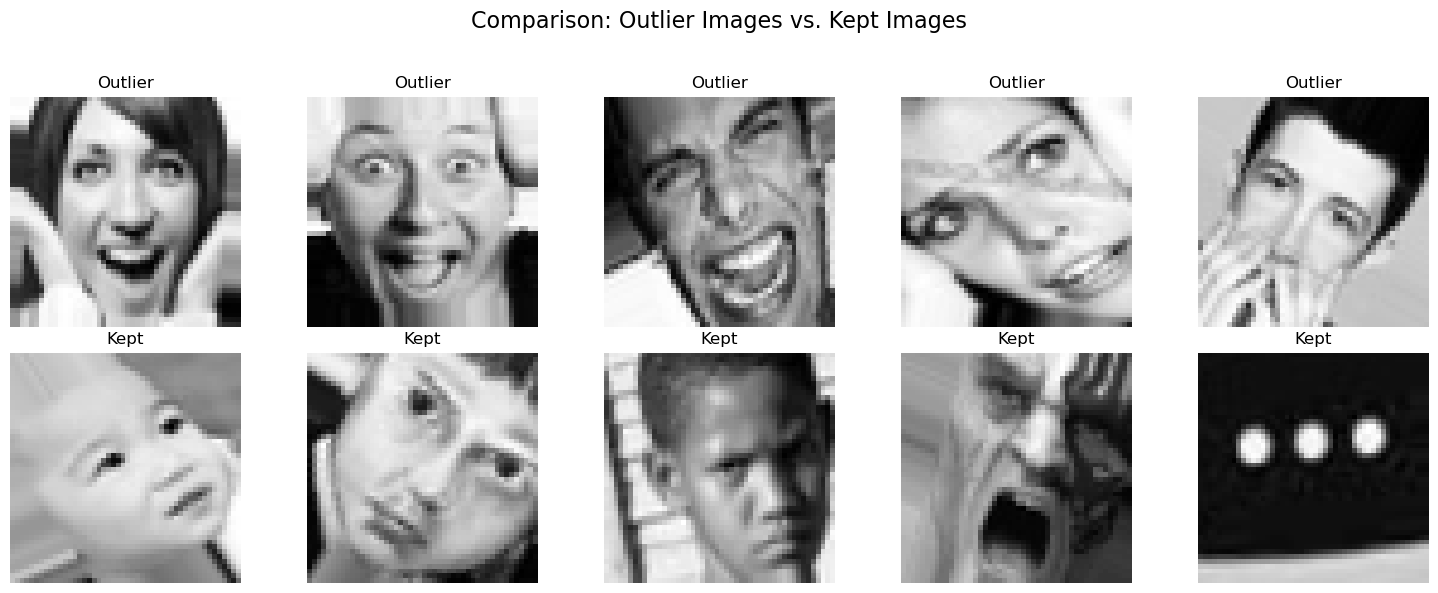

In [33]:
outlier_indices = np.where(is_outlier)[0]
kept_indices = np.where(~is_outlier)[0]

n_examples = 5
sample_outlier_indices = outlier_indices[:n_examples]
sample_kept_indices = kept_indices[:n_examples]

fig, axes = plt.subplots(2, n_examples, figsize=(15, 6))
fig.suptitle("Comparison: Outlier Images vs. Kept Images", fontsize=16)

for i, idx in enumerate(sample_outlier_indices):
    axes[0, i].imshow(all_train_imgs[idx].squeeze(), cmap="gray")
    axes[0, i].set_title("Outlier")
    axes[0, i].axis("off")

for i, idx in enumerate(sample_kept_indices):
    axes[1, i].imshow(all_train_imgs[idx].squeeze(), cmap="gray")
    axes[1, i].set_title("Kept")
    axes[1, i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Data Analysis Summary

- No Missing Data: As verified earlier, the training and test sets contain no missing pixels.

- Class Imbalance: The class "disgust" seems to be underrepresented (~300 samples), while "happy" is overrepresented (~5800 samples). This imbalance was addressed through data augmentation and class weights.

- Watermarks: A small subset of images contains watermarks. Denoising attempts (e.g., NLM) remove watermarks but blur critical facial features, possibly degrading model performance. Alternative denoising (e.g., Gaussian) didn’t seem to improve results tremendously.

- Outliers: After training a robust autoencoder, the model’s reconstruction performance on the training images improved. I chose the 98th percentile of reconstruction errors as our threshold for identifying outliers, and the model flagged a total of 459 images (which is roughly 2% of the training set) as outliers. These images include watermarked or otherwise anomalous samples that deviate from the majority of the facial expressions. By removing them, we reduced our training set to 22,477 images.

### Meaningful Insights

Based on our data analysis, we have several meaningful insights that can be used to support our goal of developing a deep learning model capable of accurately classifying human facial expressions.

1. Class imbalance: We observed signficant class imbalance in the dataset, especially with the disgust category, which had far fewer training examples compared to other classes like happy or neutural. Imbalanced training data can lead to poopr generatlization and biased prediction. Therefore, we will apply class weighting during training or perform targetd data augmentation to improve the model's ability to learn from underrepresented emotions.
2. Denoising: We found that denoising smoothed the input images while preserving improtant facial structures. Denoised inputs help the model focus on relevant facial features instead of noisy pixels. Therefore, we will apply denoising step in the preprocessing pipeline before training for more complex models.
3. Outlier detection: Our autoencoder based outlier detection found ~2% of the training data as noisy or uninformative. Many of these images had occlusions, extreme facial poses, or low contrast. Removing outliers help model generalization. Therefore, we will exclude these outliers from training to reduce overfitting and enhance class specific feature clarity.

## Research Question

Now that we've established an exhaustive EDA, we present the research questions that will guide our empirical analysis. 

1. **What is the best custom model architecture for classifying human facial expressions and how well does it perform compared to existing models in the literature?$^{[3]}$**

2. **How does the model perform for each emotion class? What are the implications of the results?**

## Baseline Model

In this section, we will run an experiment to compare two scaling methods 1) standard scaling and 2) min max scaling and use the baseline model performance to make a decision. For our very basic baseline model (more details in the next section), we will only normalize the pixel values of our training and validation set.

In [35]:
# just normalizing (min max scale) the pixel values
baseline_datagen = ImageDataGenerator(rescale=1.0 / 255)

baseline_train_datagen = baseline_datagen.flow_from_directory(
    DATA_DIR + "/train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

baseline_val_datagen = baseline_datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


We will compare the performance using the same basic model architecture trained on data with per image standardization.

In [36]:
def per_image_standardization(image):

    if isinstance(image, np.ndarray):
        image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    else:
        image_tensor = image

    standardized_image = tf.image.per_image_standardization(image_tensor)

    return standardized_image.numpy()


standardization_datagen = ImageDataGenerator(
    preprocessing_function=per_image_standardization,
)

train_std_datagen = standardization_datagen.flow_from_directory(
    DATA_DIR + "/train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

val_std_datagen = standardization_datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


Finally, the results will be compared with a model with the same architecture but trained on augmented data with normalized pixel values. The data augmentation code is highlighted in the Data Imbalance section, and we will use the `traingen` and `valgen` generators for that model. 

### Feature Scaling

For our model training, we want to make sure that we are utilizing a GPU if available and that our results are reproducible. Although MS2 does not require a baseline model, we are using a baseline model to run an experiment to determine which scaling strategy to use going forward, standard scaling or min max scaling.

In [43]:
# test if GPU is available
if tf.config.list_physical_devices("GPU"):
    print("GPU available")
else:
    print("No GPU available")

# set seeds for reproducibility
os.environ["PYTHONHASHSEED"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
tf.random.set_seed(109)
np.random.seed(109)
set_random_seed(109)


# plot accuracy
def plot_accuracy(history, plot_title="Model"):
    """
    Helper function to plot accuracy of a model.
    """

    plt.figure(figsize=(10, 6))

    best_val_acc = np.max(history.history["val_accuracy"])
    best_epoch = np.argmax(history.history["val_accuracy"])

    epochs = range(1, len(history.history["accuracy"]) + 1)

    plt.plot(epochs, history.history["accuracy"], label="Training Accuracy")
    plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy")

    plt.axvline(
        best_epoch + 1,
        color="red",
        linestyle="--",
        label=f"Best val acc: {best_val_acc:.4f}",
    )

    plt.title(f"{plot_title}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(epochs)
    plt.legend(loc="lower right")

GPU available


The baseline model will follow a very basic model architecture taken from the Lab's code. We added one regularization layer and adjust the output layer, as well as the loss function to account for the classes in our data.

In [40]:
# Very basic model
def create_baseline_model(show_summary=False):
    inputs = Input(shape=(48, 48, 1))

    x = Conv2D(64, kernel_size=(3, 3), activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(16, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(7, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    if show_summary:
        model.summary()
    
    return model

Training the most basic model with almost unprocessed data, just with the pixel values normalized.

In [41]:
baseline_model = create_baseline_model(show_summary=True)

baseline_model_history = baseline_model.fit(
    baseline_train_datagen, epochs=15, validation_data=baseline_val_datagen, verbose=1
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 16)          4624  

Baseline Model with Pixel Normalization
Train Loss: 1.1113, Train Accuracy: 0.5786
Validation Loss: 1.2812, Validation Accuracy: 0.5095


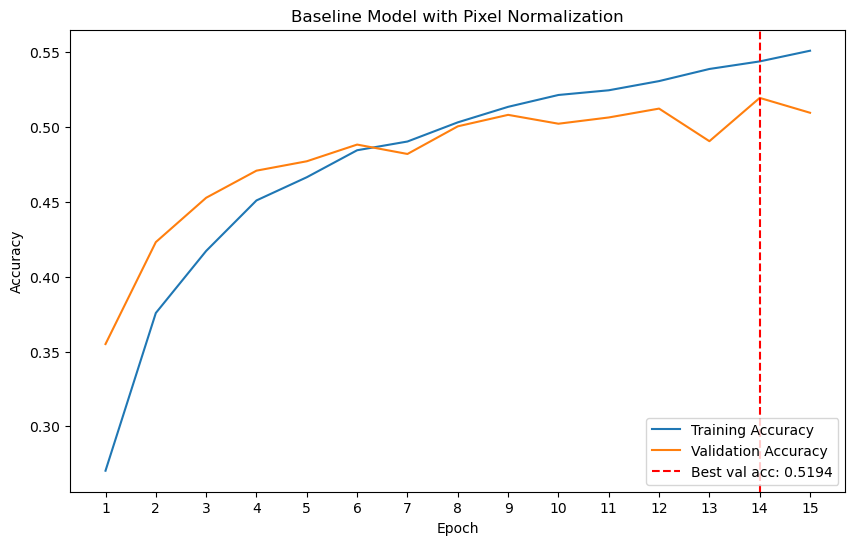

In [44]:
baseline_train_datagen.reset()
train_loss, train_acc = baseline_model.evaluate(baseline_train_datagen, verbose=0)

baseline_val_datagen.reset()
val_loss, val_acc = baseline_model.evaluate(baseline_val_datagen, verbose=0)

print("Baseline Model with Pixel Normalization")
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

plot_accuracy(baseline_model_history, "Baseline Model with Pixel Normalization")

With just these results, it is hard to tell how our model is performing. The baseline should at least inform us that: 1) our model and the data generators are working, and 2) without any preprocessing, we get a validation accuracy 44.07% after 13 epochs. However, the fact that the model is not overfitting the training data (training accuracy starts decrasing after 5 epochs) suggests there can be problems in the model implementation. Lucky for us, this is just the baseline, a rough gauge of where we're starting.

Now we want to compare the results using the same architecture, only with a slighly different preprocessing: per image standardization, instead of just dividing pixel values by 255.

In [45]:
baseline_std_model = create_baseline_model()

baseline_std_model_history = baseline_std_model.fit(
    train_std_datagen, epochs=15, validation_data=val_std_datagen, verbose=1
)

Epoch 1/15
718/718 [==============================] - 81s 112ms/step - loss: 1.6659 - accuracy: 0.3406 - val_loss: 1.5063 - val_accuracy: 0.4224
Epoch 2/15
718/718 [==============================] - 83s 116ms/step - loss: 1.4846 - accuracy: 0.4262 - val_loss: 1.4081 - val_accuracy: 0.4619
Epoch 3/15
718/718 [==============================] - 82s 114ms/step - loss: 1.3978 - accuracy: 0.4666 - val_loss: 1.3577 - val_accuracy: 0.4865
Epoch 4/15
718/718 [==============================] - 79s 110ms/step - loss: 1.3293 - accuracy: 0.4939 - val_loss: 1.3204 - val_accuracy: 0.4992
Epoch 5/15
718/718 [==============================] - 74s 103ms/step - loss: 1.2839 - accuracy: 0.5101 - val_loss: 1.2783 - val_accuracy: 0.5156
Epoch 6/15
718/718 [==============================] - 72s 100ms/step - loss: 1.2454 - accuracy: 0.5275 - val_loss: 1.2656 - val_accuracy: 0.5192
Epoch 7/15
718/718 [==============================] - 73s 102ms/step - loss: 1.2142 - accuracy: 0.5373 - val_loss: 1.2533 - val_ac

Baseline Model with Per Image Standardization
Train Loss: 0.8927, Train Accuracy: 0.6723
Validation Loss: 1.2480, Validation Accuracy: 0.5428


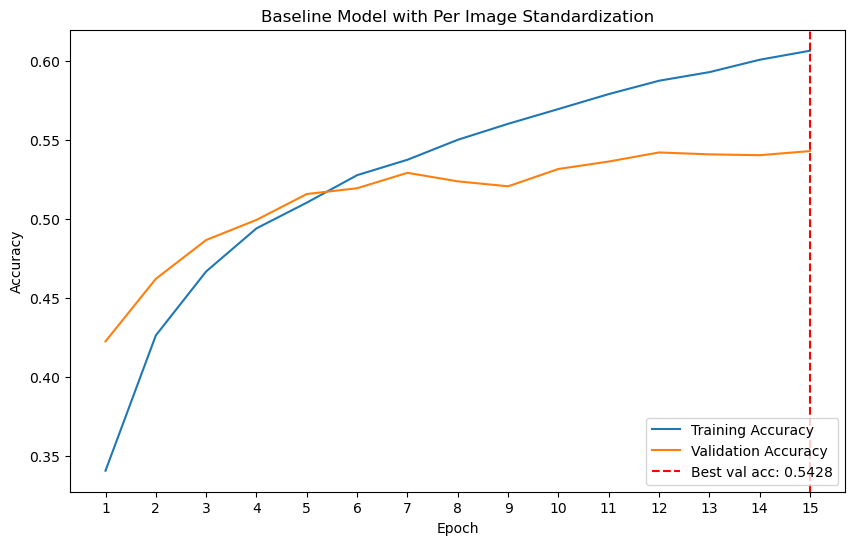

In [46]:
train_std_datagen.reset()
train_loss, train_acc = baseline_std_model.evaluate(train_std_datagen, verbose=0)

val_std_datagen.reset()
val_loss, val_acc = baseline_std_model.evaluate(val_std_datagen, verbose=0)

print("Baseline Model with Per Image Standardization")
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

plot_accuracy(
    baseline_std_model_history, "Baseline Model with Per Image Standardization"
)

Even though the best reported validation accuracy improved compared to the previous model, the training time increased significantly (as the data flow is now performing more complex calculations on each image). For future steps, we can find ways to optimize this step, if it is going to significantly improve performance. Preliminary results, however, indicate the tradeoff may not be worth it.

In [47]:
# TODO: Baseline Model
# - Add back in the data augmentation and class weights experiments
# - Use transfer learning from a SOTA model (ResNet18, VGG) to establish a baseline to aim for (upper bound).
# - remember to fine the tune the model, whichever way you see fit

# Sources: https://paperswithcode.com/sota/facial-expression-recognition-on-fer2013

### Data Augmentation

### Class Weights

### Transfer Learning

In [48]:
# TODO: Summary of Findings
# Revise paragraph below once all TODO's are complete

### Summary

In the above experiment, we implemented two methods, rescaling, dividing pixel values by 255 to normalize data within the [0,1] range and per-image standardization to normalize each image individually, addressing variations in lighting and contrast. The results show that per-image standardization will mostly be used in models as we progress with the project, given its higher validation accuracy.

For future work, we will implement data augmentation techniques, including rotation (20 degrees), width and height shifts (20%), zooming (up to 20%), and horizontal flipping to artificially expand the dataset and improve model generalization. We will also incorporate class weighting to handle the inherent imbalance across emotion categories, ensuring the model won't bias toward majority classes. Another strategy to try is to explore advanced preprocessing techniques including facial feature-specific noise reduction, contrastive learning to distinguish similar emotions like fear and surprise, and facial landmark detection to standardize orientation. Finally, we can also implemente custom data augmentation strategies that preserve emotion-specific features while varying other aspects, as this would improve our model's ability to generalize.

## Visusalizations

All visualizations above are clean, labeled, and designed to communicate insights clearly and effectively. Each plot includes appropriate titles, axis labels, and legends to ensure they are presentation- and report-ready. Below, we’ve included a series of additional visualizations that go beyond traditional EDA to assess and interpret the behavior of our trained baseline models. These visualizations help us better understand how the models make decisions, what features they rely on, and where they focus their attention. 

### Activation Maximization

I think our sample images are not suitable for deep dream. Its a very simple 48x48 grayscale image, which means that there are less room / fewer patterns to hallucinate. I'll keep the code below for now but I suggest we remove it.

Step 0, Loss: 0.0071
Step 10, Loss: 0.0072
Step 20, Loss: 0.0073
Step 30, Loss: 0.0074
Step 40, Loss: 0.0075


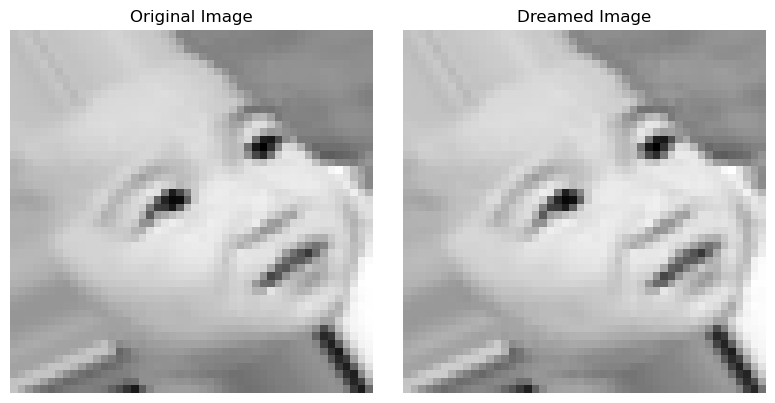

In [57]:
base_image = tf.convert_to_tensor(clean_train_imgs[0:1]) 

layer_name = [layer.name for layer in baseline_model.layers if isinstance(layer, tf.keras.layers.Conv2D)][0]
dream_layer = baseline_model.get_layer(layer_name)

dream_model = tf.keras.Model(inputs=baseline_model.input, outputs=dream_layer.output)

def compute_loss(img):
    img = tf.cast(img, tf.float32)
    activation = dream_model(img)
    return tf.reduce_mean(activation)

@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

def deep_dream(img, steps=50, learning_rate=1e-2):
    for step in range(steps):
        loss, img = gradient_ascent_step(img, learning_rate)
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.numpy():.4f}")
    return img
dreamed_img = deep_dream(base_image, steps=50)

def deprocess_image(img):
    img = img[0]
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
    img = tf.clip_by_value(img, 0, 1)
    return img.numpy().squeeze()
# visualize
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(base_image[0].numpy().squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Dreamed Image")
plt.imshow(deprocess_image(dreamed_img), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show();

### GradCAM

To better understand how our models make predictions, we used GradCAM to generate class activation heatmaps for both the baseline_model and the baseline_std_model. These visualizations show us which regions of the image the model is attending to when making its classification decision.

Key Findings:

1. Baseline Model: The GradCAM visualizations for this model were often less focused and more diffuse, sometimes highlighting background regions or unrelated areas of the face. This suggests that the baseline model did not have learned strong, localized features for the task, possibly relying on more general patterns in the image.
2. Baseline Model with Per Image Standardization: The GradCAM outputs for this model were more concentrated around the core facial features - particularly the head, nose, and mouth. This tighter focus implies that the model has learned to attend to more relevant and discriminative regions, which aligns with its improved performance metrics.

In [50]:
# !pip install tf_keras_vis

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 873.6 kB/s eta 0:00:00 0:00:01


1/1 [==============================] - 0s 16ms/step


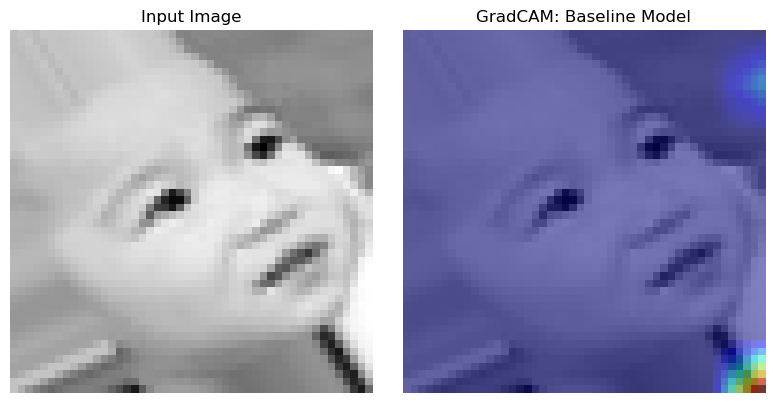

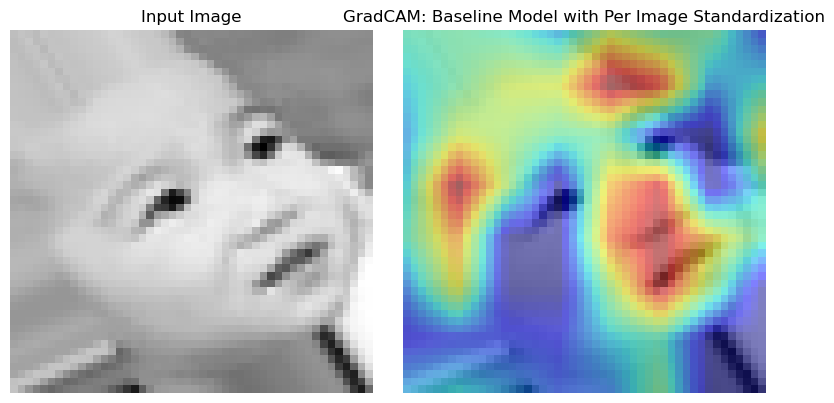

In [58]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

replace2linear = ReplaceToLinear()

def generate_gradcam(model, img, class_index):
    gradcam = Gradcam(model, model_modifier=replace2linear, clone=True)
    score = CategoricalScore([class_index])
    # This is equivalent to the above use of CategoricalScore
    # score = lambda outputs: outputs[:, class_index]
    gradcam_results = gradcam(score, img)
    return gradcam_results

def show_gradcam(model, img_array, true_class_idx, title):
    cam_result = generate_gradcam(model, img_array, true_class_idx)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img_array[0].squeeze(), cmap='gray')
    ax[0].set_title('Input Image')
    ax[0].axis('off')

    ax[1].imshow(img_array[0].squeeze(), cmap='gray')
    ax[1].imshow(cam_result[0], cmap='jet', alpha=0.5)
    ax[1].set_title(f'GradCAM: {title}')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

# We'll pick one image and generate GradCAM for both baseline models!
sample_img = clean_train_imgs[0:1] 
pred_class = np.argmax(baseline_model.predict(sample_img))

show_gradcam(baseline_model, sample_img, pred_class, title="Baseline Model")
show_gradcam(baseline_std_model, sample_img, pred_class, title="Baseline Model with Per Image Standardization")

## Sources

1. https://en.wikipedia.org/wiki/Non-local_means
2. https://docs.opencv.org/3.4/d1/d79/group__photo__denoise.html#ga03aa4189fc3e31dafd638d90de335617
3. https://paperswithcode.com/sota/facial-expression-recognition-on-fer2013

## Appendix

### Mathematical Formulae

The NLM algorithm is defined as the following transformation. Let $u(p)$ be the transformed pixel value at position $p$ in the image. $C(p)$ is a normalizing constant and $\Omega$ is the set of pixels in the image. $v(q)$ is the untransformed pixel.

$$
u(p) = \frac{1}{C(p)} \sum_{q \in \Omega} v(q) \cdot w(p,q) dq
$$

The weight function $w(p,q)$ is defined as follows:

$$
w(p,q) = exp(- \frac{|B(q) - B(p)|^2}{h^2}).
$$

$h$ is the parameter we pass into the NLM function. It controls the strength of the denoising. A larger value of $h$ means more smoothing and less detail. $B(p)$ is a patch of pixels around the pixel p. The size of the patch is defined by the parameter `templateWindowSize`. $B(q)$ is a patch of pixels around the pixel q. The size of the patch is defined by the parameter `searchWindowSize`. The weight measures how similar the patches $B(p)$ and $B(q)$ are. The weight will be larger if the patches are more similar.
